In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import sys
import os
# Importing
import gc, os, csv
from catenets.models.jax import TNet, SNet1,SNet2,DRNet,RNet
from catenets.models.torch import SLearner
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import torch
sys.path.append(os.path.abspath('../../data/simulation'))
from utils import tr_te_split,gen_1d_data, backdoor_dgp, frontdoor_dgp, instrument_dgp, simulated_study_2

## Synthetic data generation process

Generate synthetic data for M=2 outcomes.

1. **Generating Covariates (X)**:
   - A matrix `X` of shape `(N, P)` is generated, where `N` is the number of samples and `P` is the number of features. $X_{i,j} \sim Unif(-3,3)$ for $j \in \{1,2,...,P\}$ and $i \in \{1,2,...,N\}$. 

2. **Generate action allocation policy**
   - The action allocation policy is simulated according to a multinomial distribution where the probabilities of being assigned to action $A_i$ = a are generated as a softmax function of the covariates
   - $$P(A_i = a |X_i=x_i) = \frac{exp\{X_i \beta_a\}}{\sum_{a \in A} exp\{X_i \beta_a\}}$$
   - $\beta_a$ is an action-specific P-dimensional sparse vector of action-specific coefficients defined as follow:
        - $\beta_1 = [-1, -0.8, -0.1, -0.1, 0, \ldots, 0]$
        - $\beta_2 = [0, 0, 1, 0.8, 0.2, 0, \ldots, 0]$
      <!--
        - $\beta_3 = [1.5, -0.8, -0.1, -0.1, 0, \ldots, 0]$
        - $\beta_4 = [-1, -0.8, -0.1, -0.1, 0, \ldots, 0]$ -->

3. **Generating Outcomes (Y) and Costs (C)**:

    - Thus \( A_i \) is drawn from a multinomial with vector probabilities parameter $p(A_i = a|X_i = x_i)$. The $M = 2$ action-specific correlated counterfactual outcomes $Y_i | do(A_i = a)$ instead are generated as

    - $Y_i | do(A_i = a) = f_{Y_a} (X_i) + e_i, \quad e_i \sim N(0, \Sigma_{e_i})$

    - where:
        - $f_{y11} = 3 + 0.4X_0X_1 - 0.3X_2^2 + 0.2 \exp(X_3) + 0.6 \sin(X_4)$
        - $f_{y12} = -1 + f_{y11} + 0.1X_5$
        - $f_{y21} = 1 + 0.2X_0X_1 - 0.2X_2^2 + 0.1 \exp(X_3)$
        - $f_{y22} = -2 + f_{y21} + 0.2X_5$
        - where $diag(\Sigma_{e_i}) = [\sigma_1, ..., \sigma_4]$, with $\sigma_1 = ... = \sigma_4 = 0.5$
      <!--
        - $f_{y13} = 1 + f_{y11} + 0.3X_5$
        - $f_{y14} = 0.5 + f_{y11} + 0.5X_6$
        - $f_{y21} = 1 + 0.2X_0X_1 - 0.2X_2^2 + 0.1 \exp(X_3)$
        - $f_{y22} = -2 + f_{y21} + 0.2X_5$
        - $f_{y23} = 2 + f_{y21} + 0.4X_5$
        - $f_{y24} = 1 + f_{y21} + 0.5X_6$
        - where $diag(\Sigma_{e_i}) = [\sigma_1, ..., \sigma_4]$, with $\sigma_1 = ... = \sigma_4 = 0.5$

In [5]:
def evaluate_cate(N, P, seed, learner_cls):
    """
    Evaluates CATE predictions using a specified learner, and plots results for the last N.
    
    Parameters:
        N (list): List of sample sizes to be evaluated.
        P (int): Number of features in the dataset.
        seed (int): Random seed for reproducibility.
        learner_cls: Class of the learner to be used for CATE estimation.
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

    for idx, n in enumerate(N):
        print("\n********** Iteration N:", n)
        
        # Generate Data
        X, A, Y, C, Y_true, C_true = backdoor_dgp(N=n, P=P, rng=seed)

        # Train-Test Split (80-20%)
        split = np.random.choice(np.array([True, False]), n, replace=True, p=np.array([0.8, 0.2]))

        X_train, X_test = tr_te_split(X, split)
        A_train, A_test = tr_te_split(A, split)
        Y_train, Y_test = tr_te_split(Y, split)
        C_train, C_test = tr_te_split(C, split)

        Y_true_train, Y_true_test = tr_te_split(Y_true, split)
        C_true_train, C_true_test = tr_te_split(C_true, split)

        Y_true_test_cate = Y_true_test[:, 1] - Y_true_test[:, 0]
        C_true_test_cate = C_true_test[:, 1] - C_true_test[:, 0]

        # Instantiate and train the learner for Y
        #model_y = learner_cls()
        if learner_cls.__name__ == 'SLearner':
            model_y = learner_cls(n_unit_in=P, binary_y=False)
        else:
            model_y = learner_cls()
        model_y.fit(X=X_train, y=Y_train, w=A_train)
        cate_pred_y = model_y.predict(X_test)  # predict potential outcomes

        # Instantiate and train the learner for C
        #model_c = learner_cls()
        if learner_cls.__name__ == 'SLearner':
            model_c = learner_cls(n_unit_in=P, binary_y=False)
        else:
            model_c = learner_cls()
        model_c.fit(X=X_train, y=C_train, w=A_train)
        
        cate_pred_c = model_c.predict(X_test)  # predict potential outcomes

        # Compute RMSE for the treatment effects predicted by model_y and model_c
        if learner_cls.__name__ == 'SLearner':
            rmse_y = np.sqrt(mean_squared_error(Y_true_test_cate, cate_pred_y.cpu().detach().numpy()))
            rmse_c = np.sqrt(mean_squared_error(C_true_test_cate, cate_pred_c.cpu().detach().numpy()))
        else:
            rmse_y = np.sqrt(mean_squared_error(Y_true_test_cate, cate_pred_y))
            rmse_c = np.sqrt(mean_squared_error(C_true_test_cate, cate_pred_c))

        print("RMSE for treatment effect by t_Y:", rmse_y)
        print("RMSE for treatment effect by t_C:", rmse_c)

        # Plotting for the last element in N
        if learner_cls.__name__ == 'SLearner':
            cate_pred_y = cate_pred_y.cpu().detach().numpy()
            cate_pred_c = cate_pred_c.cpu().detach().numpy()
            
        if idx == len(N) - 1:
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.scatter(Y_true_test_cate, cate_pred_y, alpha=0.5)
            plt.plot([Y_true_test_cate.min(), Y_true_test_cate.max()], [Y_true_test_cate.min(), Y_true_test_cate.max()], 'k--')
            plt.xlabel('True CATE')
            plt.ylabel('Predicted CATE ($t_Y$)')
            plt.title('True vs Predicted CATE (Model $t_Y$)')

            plt.subplot(1, 2, 2)
            plt.scatter(C_true_test_cate, cate_pred_c, alpha=0.5)
            plt.plot([C_true_test_cate.min(), C_true_test_cate.max()], [C_true_test_cate.min(), C_true_test_cate.max()], 'k--')
            plt.xlabel('True CATE')
            plt.ylabel('Predicted CATE ($t_C$)')
            plt.title('True vs Predicted CATE (Model $t_C$)')

            plt.show()

## S-leaner


********** Iteration N: 1000
RMSE for treatment effect by t_Y: 0.3131608456845398
RMSE for treatment effect by t_C: 0.32460862354916564

********** Iteration N: 1500
RMSE for treatment effect by t_Y: 0.3422212452835462
RMSE for treatment effect by t_C: 0.24098718232439567

********** Iteration N: 2000
RMSE for treatment effect by t_Y: 0.24939991454235166
RMSE for treatment effect by t_C: 0.25843602450347

********** Iteration N: 2500
RMSE for treatment effect by t_Y: 0.2750435184577176
RMSE for treatment effect by t_C: 0.20622302409423945

********** Iteration N: 3000
RMSE for treatment effect by t_Y: 0.25259258654519623
RMSE for treatment effect by t_C: 0.2037531087446996


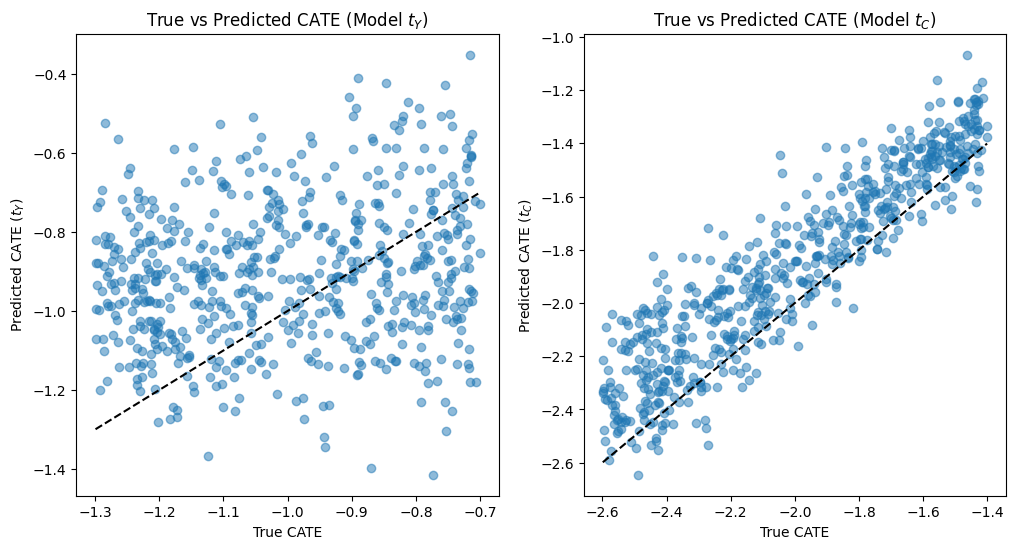

In [3]:
evaluate_cate(N=[1000, 1500, 2000, 2500, 3000], P=10, seed=123, learner_cls=SLearner)

## T-learner


********** Iteration N: 1000
RMSE for treatment effect by t_Y: 0.8329022598760737
RMSE for treatment effect by t_C: 0.5305084078111085

********** Iteration N: 1500
RMSE for treatment effect by t_Y: 0.8467602673253704
RMSE for treatment effect by t_C: 0.6398968528994706

********** Iteration N: 2000
RMSE for treatment effect by t_Y: 0.681450127603094
RMSE for treatment effect by t_C: 0.4205830085734737

********** Iteration N: 2500
RMSE for treatment effect by t_Y: 0.6425565198276265
RMSE for treatment effect by t_C: 0.3699046319042723

********** Iteration N: 3000
RMSE for treatment effect by t_Y: 0.5354233765910994
RMSE for treatment effect by t_C: 0.34153160537199206


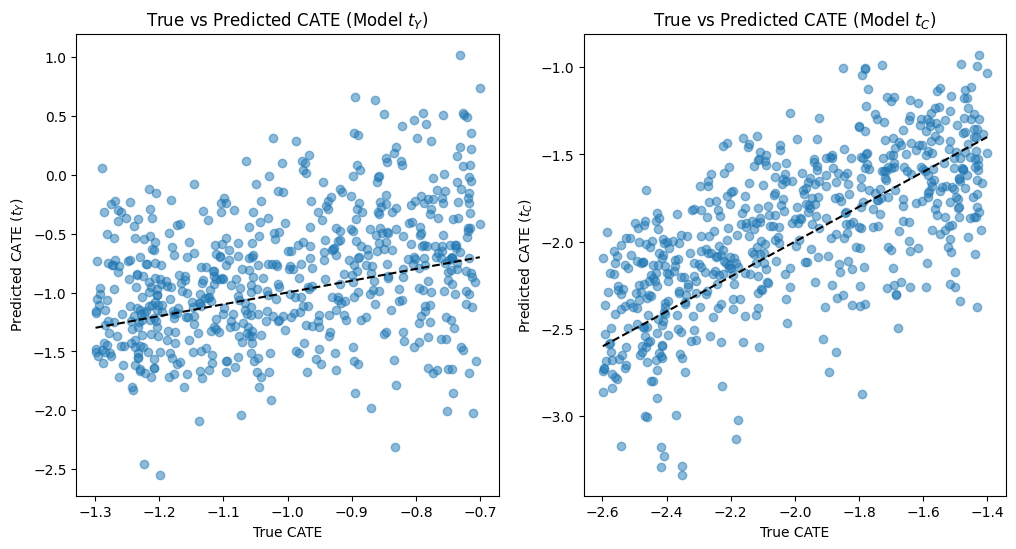

In [6]:
evaluate_cate(N=[1000, 1500, 2000, 2500, 3000], P=10, seed=123, learner_cls=TNet)

## R-Net


********** Iteration N: 1000
RMSE for treatment effect by t_Y: 0.5342268082973509
RMSE for treatment effect by t_C: 0.5412739225561134

********** Iteration N: 1500
RMSE for treatment effect by t_Y: 0.5559167567359322
RMSE for treatment effect by t_C: 0.5494789026479628

********** Iteration N: 2000
RMSE for treatment effect by t_Y: 0.3922829876105133
RMSE for treatment effect by t_C: 0.4697551266347414

********** Iteration N: 2500
RMSE for treatment effect by t_Y: 0.4038698137153791
RMSE for treatment effect by t_C: 0.40364897215216067

********** Iteration N: 3000
RMSE for treatment effect by t_Y: 0.37486058865614397
RMSE for treatment effect by t_C: 0.3658233494931913


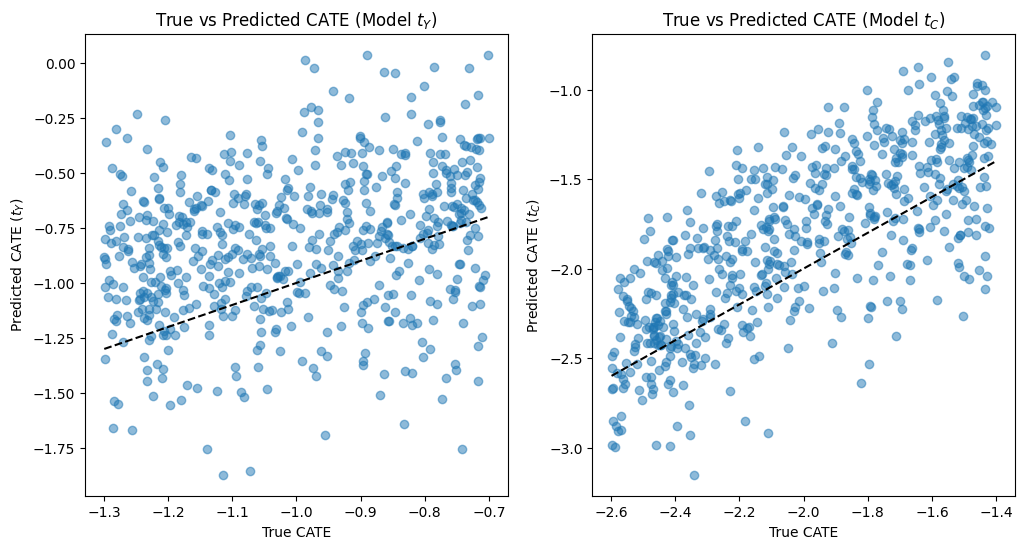

In [7]:
evaluate_cate(N=[1000, 1500, 2000, 2500, 3000], P=10, seed=123, learner_cls=RNet)

## TARNet


********** Iteration N: 1000
RMSE for treatment effect by t_Y: 1.0581753500856879
RMSE for treatment effect by t_C: 0.6708461177944978

********** Iteration N: 1500
RMSE for treatment effect by t_Y: 0.694157874178452
RMSE for treatment effect by t_C: 0.5337166486027255

********** Iteration N: 2000
RMSE for treatment effect by t_Y: 0.5123998498629714
RMSE for treatment effect by t_C: 0.42333557432364

********** Iteration N: 2500
RMSE for treatment effect by t_Y: 0.5166404791526775
RMSE for treatment effect by t_C: 0.3459317356992177

********** Iteration N: 3000
RMSE for treatment effect by t_Y: 0.5012154922838649
RMSE for treatment effect by t_C: 0.3828597471552216


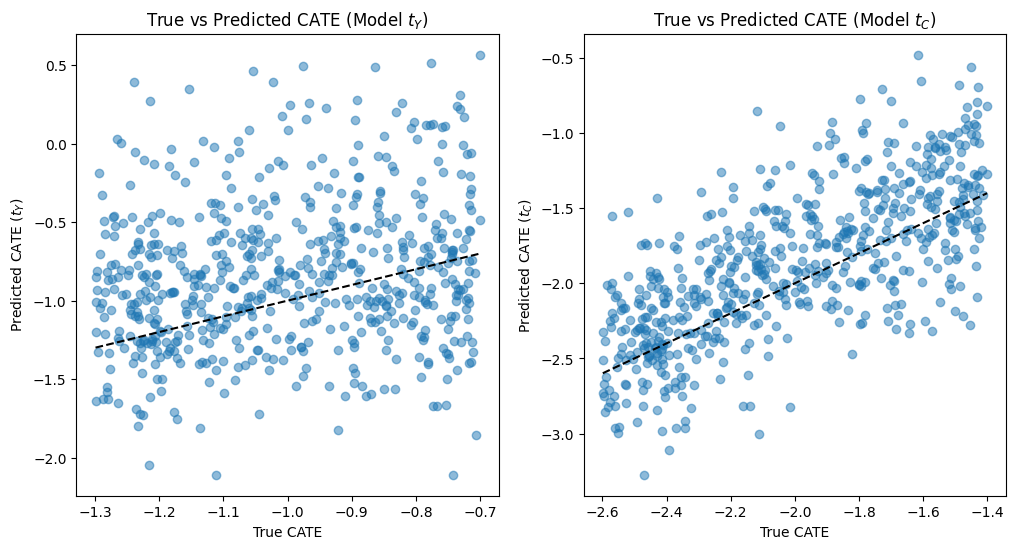

In [8]:
evaluate_cate(N=[1000, 1500, 2000, 2500, 3000], P=10, seed=123, learner_cls=SNet1)

## DragonNet


********** Iteration N: 1000
RMSE for treatment effect by t_Y: 1.089138552675076
RMSE for treatment effect by t_C: 0.7088731424605109

********** Iteration N: 1500
RMSE for treatment effect by t_Y: 0.6912316419499704
RMSE for treatment effect by t_C: 0.5216157869936134

********** Iteration N: 2000
RMSE for treatment effect by t_Y: 0.4831435963932317
RMSE for treatment effect by t_C: 0.42475063166947286

********** Iteration N: 2500
RMSE for treatment effect by t_Y: 0.5158393151351255
RMSE for treatment effect by t_C: 0.3448672580976804

********** Iteration N: 3000
RMSE for treatment effect by t_Y: 0.4722387036495592
RMSE for treatment effect by t_C: 0.36738463139921074


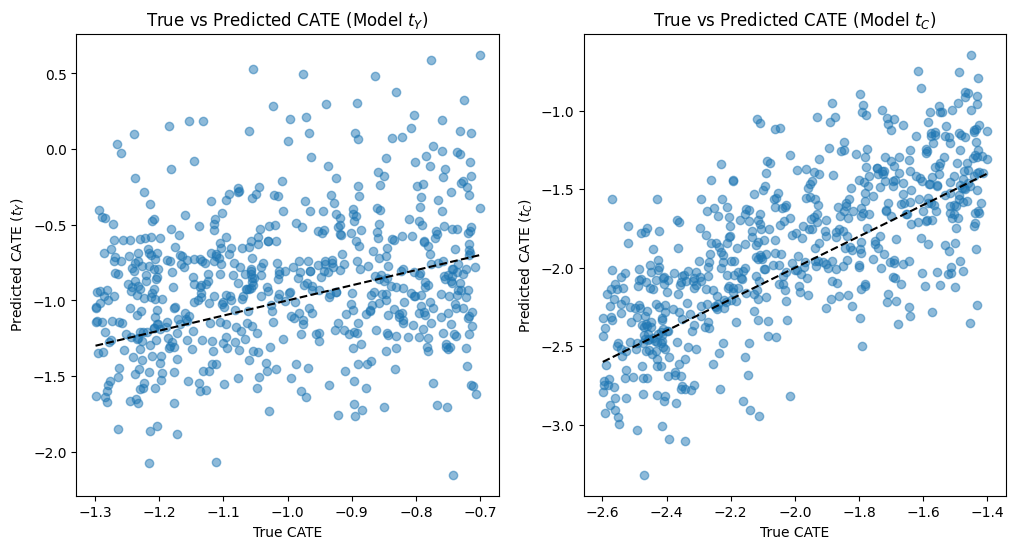

In [9]:
evaluate_cate(N=[1000, 1500, 2000, 2500, 3000], P=10, seed=123, learner_cls=SNet2)

## DRNet


********** Iteration N: 1000
RMSE for treatment effect by t_Y: 0.7824129836349137
RMSE for treatment effect by t_C: 0.5262464820142095

********** Iteration N: 1500
RMSE for treatment effect by t_Y: 0.7838314012755092
RMSE for treatment effect by t_C: 0.6879719979846226

********** Iteration N: 2000
RMSE for treatment effect by t_Y: 0.5868375073096751
RMSE for treatment effect by t_C: 0.4017577909741224

********** Iteration N: 2500
RMSE for treatment effect by t_Y: 0.534014011009653
RMSE for treatment effect by t_C: 0.513252257379864

********** Iteration N: 3000
RMSE for treatment effect by t_Y: 0.4705043664773396
RMSE for treatment effect by t_C: 0.35505330097537313


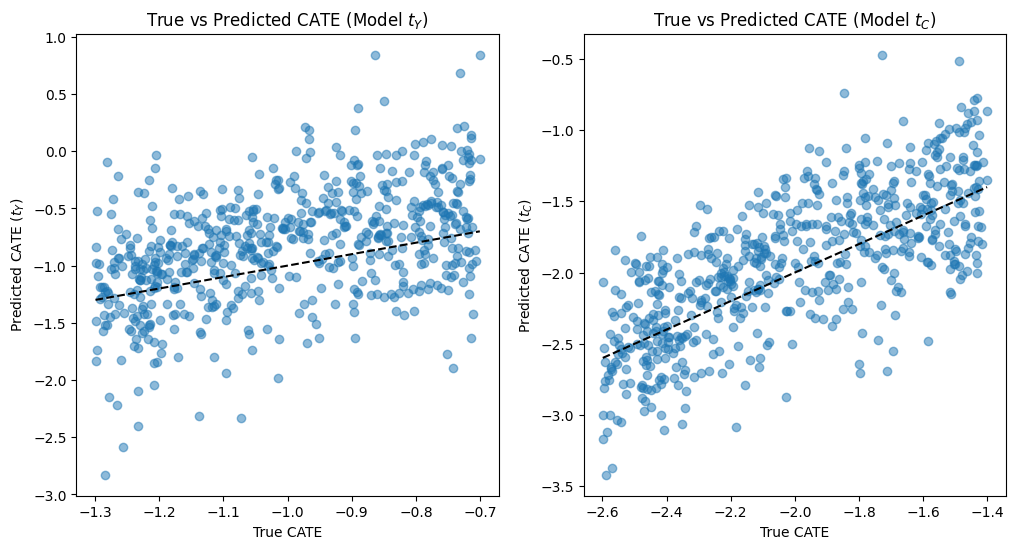

In [10]:
evaluate_cate(N=[1000, 1500, 2000, 2500, 3000], P=10, seed=123, learner_cls=DRNet)